# Dane Jordan

## Homework 4 Data Competition Milestones

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import urllib.request

from IPython.core.interactiveshell import InteractiveShell
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
def computeobj(beta, lamb, x, y):
    # number of observations
    n = x.shape[0]
    
    # compute objective function
    obj = (1/n)*(np.sum(np.log(1 + np.exp(-y*np.dot(x, beta))))) + lamb*np.sum(beta**2)
    
    return obj


def computegrad(beta, lamb, x, y):
    # number of observations
    n = x.shape[0]
    
    # compute gradient of objective function
    grad_beta = -(1/n)*(np.dot(x.T, y/(np.exp(y*np.dot(x, beta)) + 1))) + 2*lamb*beta
    
    return grad_beta


def backtracking(beta, lamb, x, y, eta=1, alpha=0.5, gamma=0.8, max_iter=100):
    # initialize variables
    grad_beta = computegrad(beta, lamb, x, y)
    norm_grad_beta = np.sqrt(np.sum(grad_beta**2))
    found_eta = 0
    t = 0
    
    # loop through until eta found or max iterations reached
    while found_eta == 0 and t < max_iter:
        if (computeobj(beta - eta*grad_beta, lamb, x, y) <
                computeobj(beta, lamb, x, y) - alpha*eta*norm_grad_beta**2):
            found_eta = 1
        elif t == max_iter:
            break
        else:
            eta = eta*gamma
            t += 1
    
    return eta


def fastgradalgo(beta_init, theta_init, lamb, x, y, max_iter, eps):
    # initialize variables
    beta = beta_init
    theta = theta_init
    grad_theta = computegrad(theta, lamb, x, y)
    eta_init = 1/(max(np.linalg.eigh(np.dot((1/n)*x.T, x))[0]) + lamb)
    beta_vals = [beta_init]
    t = 0
    
    # loop through until EITHER max iterations reached or threshold of epsilon reached
    while t < max_iter and np.linalg.norm(grad_theta) >  eps:
        eta = backtracking(beta, lamb, x, y, eta=eta_init)
        beta_next = theta - eta*grad_theta
        theta = beta_next + t*(beta_next - beta)/(t + 3)
        grad_theta = computegrad(theta, lamb, x, y)
        beta = beta_next
        beta_vals.append(beta)
        t += 1
        
    return beta_vals

- Pick two classes of your choice from the dataset. Train an $\ell_2^2$-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with $\lambda=1$. Plot, with diﬀerent colors, the _misclassiﬁcation error_ on the training set and on the validation set vs iterations.

In [3]:
# load training data
x = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/train_features'))
y = np.array(pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/train_labels')))
y = y.astype(float)

# subset the data for the first two classes
index = np.argwhere([y == 42, y == 112])
x_subset = x[index[:, 1]]
y_subset = y[index[: ,1]]
y_subset[y_subset == 42] = -1
y_subset[y_subset == 112] = 1

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_subset, y_subset, random_state=0)

# center and standardize x values
x_scaler = StandardScaler().fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

# dimensional data
n = x_train.shape[0]
d = x_train.shape[1]

# initialize betas and thetas
beta_init = np.zeros(d)
theta_init = np.zeros(d)

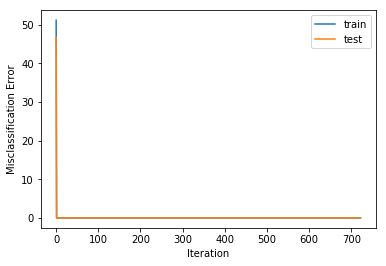

In [4]:
# train logistic regression with fast gradient algorithm (lambda = 1)
betas = fastgradalgo(beta_init=beta_init, theta_init=theta_init, lamb=1, x=x_train, y=y_train, max_iter=1000, eps=1e-5) 

# loop through betas and plot misclassification error
misclass_train = []
misclass_test = []

for i in range(len(betas)):
    y_predict_train = np.dot(x_train, betas[i])
    y_predict_test = np.dot(x_test, betas[i])
    y_predict_train[y_predict_train >= 0] = 1
    y_predict_train[y_predict_train < 0] = -1
    y_predict_test[y_predict_test >= 0] = 1
    y_predict_test[y_predict_test < 0] = -1
    misclass_train.append(np.mean(y_predict_train != y_train)*100)
    misclass_test.append(np.mean(y_predict_test != y_test)*100)

# generate plots
plt.plot(misclass_train);
plt.plot(misclass_test);
plt.legend(['train', 'test']);
plt.xlabel('Iteration');
plt.ylabel('Misclassification Error');

- Find the value of the regularization parameter $\lambda$ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an $\ell_2^2$-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with that value of $\lambda$ found by cross-validation. Plot, with diﬀerent colors, the _misclassiﬁcation error_ on the training set and on the validation set vs iterations.

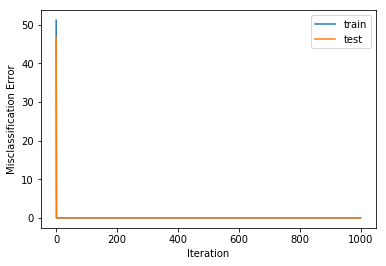

In [5]:
# use sklearn to find optimal lambda
logitCV = LogisticRegressionCV(fit_intercept=False, max_iter=1000).fit(x_train, y_train)
opt_lamb = logitCV.C_

# train logistic regression with fast gradient algorithm (lambda = optimal lambda = 0.0001)
betas = fastgradalgo(beta_init=beta_init, theta_init=theta_init, lamb=opt_lamb, x=x_train, y=y_train, max_iter=1000, eps=1e-5) 

# loop through betas and plot misclassification error
misclass_train = []
misclass_test = []

for i in range(len(betas)):
    y_predict_train = np.dot(x_train, betas[i])
    y_predict_test = np.dot(x_test, betas[i])
    y_predict_train[y_predict_train >= 0] = 1
    y_predict_train[y_predict_train < 0] = -1
    y_predict_test[y_predict_test >= 0] = 1
    y_predict_test[y_predict_test < 0] = -1
    misclass_train.append(np.mean(y_predict_train != y_train)*100)
    misclass_test.append(np.mean(y_predict_test != y_test)*100)

# generate plots
plt.plot(misclass_train);
plt.plot(misclass_test);
plt.legend(['train', 'test']);
plt.xlabel('Iteration');
plt.ylabel('Misclassification Error');